In [53]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '2d-floor-plan-dataset-with-text-descriptions-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4855355%2F8196933%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T004506Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95ad6097a2acd1fddf92d8ce31269c054ea5843406bf07dc7ce36f080e96854e89d45f00bca2516898b4968f1c5a5c1e601ff2c531ee89dc1bde834fd66a504cbb75c5f1d775f2c2e7cd88024385f26451f9e21e8b6123ecc42d92c3d658c4e81ffd0a41ad67fb07514dd5fd5815baa56ffedebdbeff16cb1b005109f92041797a885ee380a4968921e78a96e2d09ecec7ebc2c9062d8e74f8ddb00fc0cad8dfc53645308ee5369555c4e131a41eb1b93d00d8bd0fe0aac3b29f3bfe1450cc16c325d3c3f06f888acc64c7614b9a315929678fc35fa44cf7477e3e36497199c649b7f053255ce9c19cf7fb5f4e763a6bfce31b4d07c2022d02ddecf9e974ce55'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16912614 bytes downloaded
Downloaded and uncompressed: 2d-floor-plan-dataset-with-text-descriptions-new
Data source import complete.


## Loading Dataframe and Importing Libraries

In [54]:
import numpy as np
import pandas as pd
import os

In [55]:
df = pd.read_pickle("/kaggle/input/2d-floor-plan-dataset-with-text-descriptions-new/word_embeddings_dataframe.pkl")
df.head()

,File_Name,Text,Image_Path,BERT_Embeddings
0,10017,"The balcony juts out on the south side, with t...",../floorplan_image\10017.png,"[[-0.6216691, -0.029034398, 0.045137372, -0.09..."
1,10042,The balcony is in the southeastern corner of t...,../floorplan_image\10042.png,"[[-0.6944888, 0.015425202, -0.0041255075, -0.1..."
2,10045,"bathroom is in north side of the house, next t...",../floorplan_image\10045.png,"[[-0.6030773, -0.0011889015, 0.045667697, -0.1..."
3,10047,"The balcony is in the north east corner, just ...",../floorplan_image\10047.png,"[[-0.69215715, -0.052971497, 0.03891414, -0.02..."
4,10052,The balcony is on the southwest side of the ap...,../floorplan_image\10052.png,"[[-0.61126614, -0.005761562, -0.054692637, 0.0..."


## Adjusting Image path according to Kaggle

In [56]:
# Function to modify image path
def modify_image_path(image_path):
    filename = os.path.basename(image_path).split("floorplan_image\\")[1]
    new_path = os.path.join("human_annotated_images", filename)
    return new_path

# Apply the function to the 'Image_Path' column in the DataFrame
df['Modified_Image_Path'] = df['Image_Path'].apply(modify_image_path)

df.head()

,File_Name,Text,Image_Path,BERT_Embeddings,Modified_Image_Path
0,10017,"The balcony juts out on the south side, with t...",../floorplan_image\10017.png,"[[-0.6216691, -0.029034398, 0.045137372, -0.09...",human_annotated_images/10017.png
1,10042,The balcony is in the southeastern corner of t...,../floorplan_image\10042.png,"[[-0.6944888, 0.015425202, -0.0041255075, -0.1...",human_annotated_images/10042.png
2,10045,"bathroom is in north side of the house, next t...",../floorplan_image\10045.png,"[[-0.6030773, -0.0011889015, 0.045667697, -0.1...",human_annotated_images/10045.png
3,10047,"The balcony is in the north east corner, just ...",../floorplan_image\10047.png,"[[-0.69215715, -0.052971497, 0.03891414, -0.02...",human_annotated_images/10047.png
4,10052,The balcony is on the southwest side of the ap...,../floorplan_image\10052.png,"[[-0.61126614, -0.005761562, -0.054692637, 0.0...",human_annotated_images/10052.png


In [57]:
df.drop(['Image_Path'], axis = 1, inplace = True)

In [58]:
df.rename(columns = {'Modified_Image_Path':'Image_Path'}, inplace = True)
df.head()

,File_Name,Text,BERT_Embeddings,Image_Path
0,10017,"The balcony juts out on the south side, with t...","[[-0.6216691, -0.029034398, 0.045137372, -0.09...",human_annotated_images/10017.png
1,10042,The balcony is in the southeastern corner of t...,"[[-0.6944888, 0.015425202, -0.0041255075, -0.1...",human_annotated_images/10042.png
2,10045,"bathroom is in north side of the house, next t...","[[-0.6030773, -0.0011889015, 0.045667697, -0.1...",human_annotated_images/10045.png
3,10047,"The balcony is in the north east corner, just ...","[[-0.69215715, -0.052971497, 0.03891414, -0.02...",human_annotated_images/10047.png
4,10052,The balcony is on the southwest side of the ap...,"[[-0.61126614, -0.005761562, -0.054692637, 0.0...",human_annotated_images/10052.png


# Printing an Image

In [59]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/2d-floor-plan-dataset-with-text-descriptions-new
/kaggle/input/2d-floor-plan-dataset-with-text-descriptions-new/human_annotated_images


In [60]:
DIRECTORY = "/kaggle/input/2d-floor-plan-dataset-with-text-descriptions-new/"

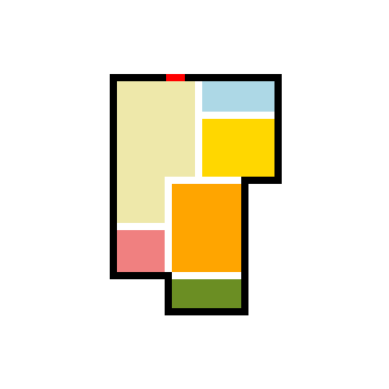

In [61]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = DIRECTORY + df['Image_Path'][0]

image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

# Splitting Dataset into test and Train

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

X_text_embeddings = np.array(df['BERT_Embeddings'].tolist())
image_paths = df['Image_Path'].tolist()

X_images = []
for path in image_paths:
    path = DIRECTORY + path
    image = Image.open(path)
    image_array = np.array(image) / 255.0
    X_images.append(image_array)

X_text_embeddings = np.array(X_text_embeddings)
X_images = np.array(X_images)

y = np.arange(len(df))

X_train_text, X_test_text, X_train_images, X_test_images, y_train, y_test = train_test_split(
    X_text_embeddings, X_images, y, test_size=0.1, random_state=42
)

print("X_train_text shape:", X_train_text.shape)
print("X_train_images shape:", X_train_images.shape)
print("y_train shape:", y_train.shape)
print("X_test_text shape:", X_test_text.shape)
print("X_test_images shape:", X_test_images.shape)
print("y_test shape:", y_test.shape)


X_train_text shape: (3602, 1, 768)
X_train_images shape: (3602, 256, 256, 3)
y_train shape: (3602,)
X_test_text shape: (401, 1, 768)
X_test_images shape: (401, 256, 256, 3)
y_test shape: (401,)


In [63]:
X_train_text = X_train_text.reshape(X_train_text.shape[0], -1)
X_test_text = X_test_text.reshape(X_test_text.shape[0], -1)

print("Reshaped X_train_text shape:", X_train_text.shape)
print("Reshaped X_test_text shape:", X_test_text.shape)

Reshaped X_train_text shape: (3602, 768)
Reshaped X_test_text shape: (401, 768)


### Shape of Final Data

In [64]:
print("X_train_text shape:", X_train_text.shape)
print("X_train_images shape:", X_train_images.shape)

print("X_test_text shape:", X_test_text.shape)
print("X_test_images shape:", X_test_images.shape)

X_train_text shape: (3602, 768)
X_train_images shape: (3602, 256, 256, 3)
X_test_text shape: (401, 768)
X_test_images shape: (401, 256, 256, 3)


In [65]:
type(X_train_images)

numpy.ndarray

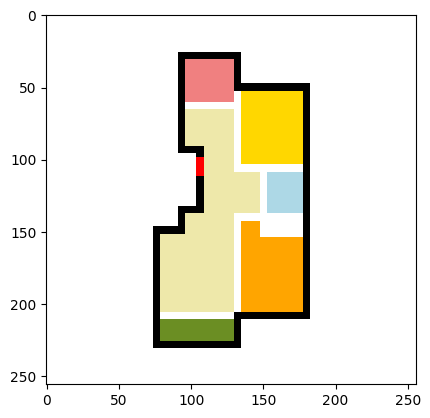

In [66]:
data = X_train_images[2]
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

In [67]:
X_train_images.shape

(3602, 256, 256, 3)

## Resizing images to lower dimension

In [68]:
import cv2
resized_images = []

new_width = 64
new_height = 64

for image in X_train_images:
    resized_img = cv2.resize(image, (new_width, new_height))
    resized_images.append(resized_img)

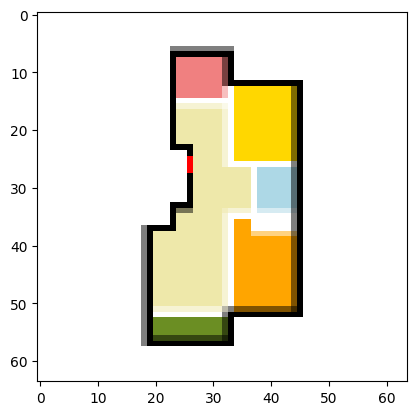

In [69]:
data = resized_images[2]
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

In [70]:
X_train_images_resized = np.array(resized_images)

In [71]:
print(X_train_images_resized.shape)
print(X_train_text.shape)

(3602, 64, 64, 3)
(3602, 768)


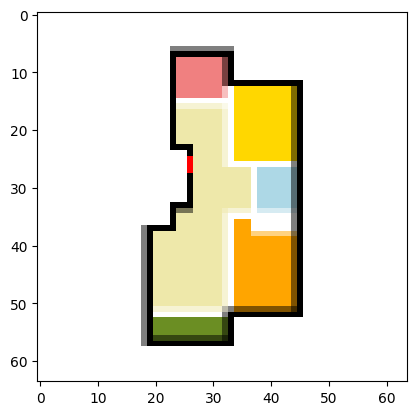

In [72]:
data = X_train_images_resized[2]
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

# Applying GANs model

In [73]:
print(X_train_images_resized.shape)
print(X_train_text.shape)

(3602, 64, 64, 3)
(3602, 768)


## Using a subset of data to train (for initial testing) (done)

In [74]:
train_images = X_train_images_resized
train_text = X_train_text

#### this train_images and train_text data will be used to train our gans model

In [75]:
print(train_images.shape)
print(train_text.shape)

(3602, 64, 64, 3)
(3602, 768)


#### testing done, now will train on entire dataset.

# Generator Architecture

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import matplotlib.pyplot as plt

def build_generator(input_size):
    model = models.Sequential()

    model.add(layers.Dense(8192, input_shape=(input_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

generator = build_generator(input_size=100)
generator.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 8192)              827392    
                                                                 
 batch_normalization_24 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 re_lu_24 (ReLU)             (None, 8192)              0         
                                                                 
 reshape_11 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_39 (Conv2  (None, 8, 8, 256)         3277056   
 DTranspose)                                                     
                                                                 
 batch_normalization_25 (Ba  (None, 8, 8, 256)       

# Discriminator Architecture

In [77]:
def build_discriminator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 8, 8, 256)         819456    
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_67 (Conv2D)          (None, 4, 4, 512)       

In [78]:
d_losses = []
g_losses = []

## Training loop

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

generator = build_generator(input_size=100)
discriminator = build_discriminator()

@tf.keras.utils.register_keras_serializable()
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_function):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_function = loss_function

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        with tf.GradientTape() as disc_tape:
            generated_images = self.generator(tf.random.normal([batch_size, 100]), training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            disc_loss = self.loss_function(tf.ones_like(real_output), real_output) + \
                        self.loss_function(tf.zeros_like(fake_output), fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:
            generated_images = self.generator(tf.random.normal([batch_size, 100]), training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.loss_function(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        return {'d_loss': disc_loss, 'g_loss': gen_loss}

gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=optimizers.Adam(1e-4),
    d_optimizer=optimizers.Adam(1e-4),
    loss_function=losses.BinaryCrossentropy()
)

# Loading Data

In [87]:
import tensorflow as tf

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_text))
train_dataset = train_dataset.shuffle(buffer_size=500).batch(batch_size)
print(train_dataset.element_spec)

d_losses = []
g_losses = []

iterations_per_epoch = len(train_dataset)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 768), dtype=tf.float32, name=None))


# Training

In [88]:
epochs = 500
for epoch in range(epochs):
    for real_images, _ in train_dataset:

        with tf.GradientTape() as disc_tape:
            generated_images = gan.generator(tf.random.normal([batch_size, 100]), training=True)
            real_output = gan.discriminator(real_images, training=True)
            fake_output = gan.discriminator(generated_images, training=True)

            disc_loss = gan.loss_function(tf.ones_like(real_output), real_output) + \
                        gan.loss_function(tf.zeros_like(fake_output), fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, gan.discriminator.trainable_variables)
        gan.d_optimizer.apply_gradients(zip(gradients_of_discriminator, gan.discriminator.trainable_variables))

        with tf.GradientTape() as gen_tape:
            generated_images = gan.generator(tf.random.normal([batch_size, 100]), training=True)
            fake_output = gan.discriminator(generated_images, training=True)
            gen_loss = gan.loss_function(tf.ones_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, gan.generator.trainable_variables)
        gan.g_optimizer.apply_gradients(zip(gradients_of_generator, gan.generator.trainable_variables))

    print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {disc_loss.numpy()}, Generator Loss: {gen_loss.numpy()}")
    d_losses.append(disc_loss.numpy())
    g_losses.append(gen_loss.numpy())

Epoch 1/500, Discriminator Loss: 1.5272932052612305, Generator Loss: 1.9655438661575317
Epoch 2/500, Discriminator Loss: 0.8361896872520447, Generator Loss: 3.627810001373291
Epoch 3/500, Discriminator Loss: 0.38694798946380615, Generator Loss: 2.705854654312134
Epoch 4/500, Discriminator Loss: 1.9388320446014404, Generator Loss: 1.2975819110870361
Epoch 5/500, Discriminator Loss: 0.840694010257721, Generator Loss: 0.9819676876068115
Epoch 6/500, Discriminator Loss: 1.371047019958496, Generator Loss: 1.5541754961013794
Epoch 7/500, Discriminator Loss: 0.6825367212295532, Generator Loss: 1.7427335977554321
Epoch 8/500, Discriminator Loss: 0.8928180932998657, Generator Loss: 2.0004115104675293
Epoch 9/500, Discriminator Loss: 0.8879518508911133, Generator Loss: 1.0263867378234863
Epoch 10/500, Discriminator Loss: 1.467569351196289, Generator Loss: 2.7936651706695557
Epoch 11/500, Discriminator Loss: 1.0111099481582642, Generator Loss: 1.8642077445983887
Epoch 12/500, Discriminator Loss: 

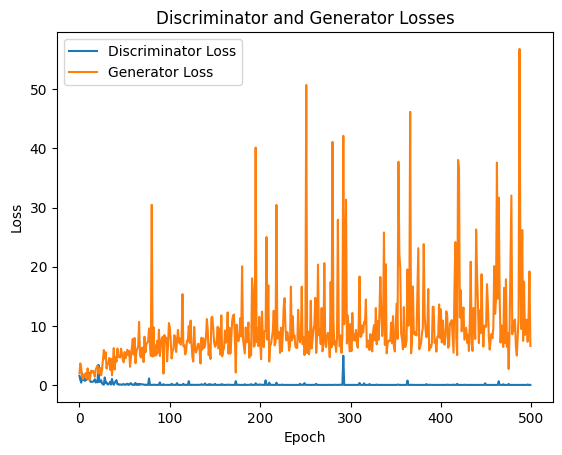

In [89]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.legend()
plt.show()

In [93]:
gan.save('gan_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [91]:
train_images.shape[0]

3602

# Generated Images

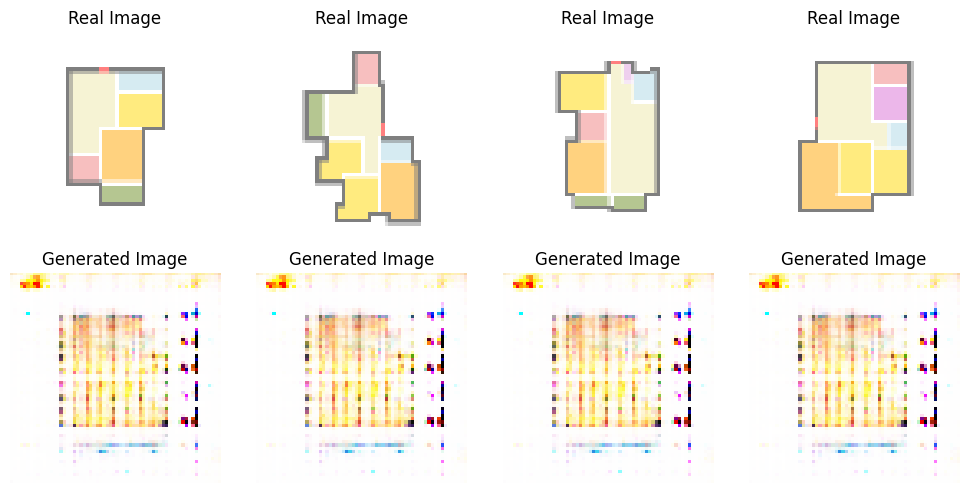

In [92]:
import matplotlib.pyplot as plt
import numpy as np

num_images_to_display = 4
random_indices = np.random.choice(train_images.shape[0], size=num_images_to_display, replace=False)
random_real_images = train_images[random_indices]

noise_dim = 100
noise = np.random.normal(size=(num_images_to_display, noise_dim))
generated_images = generator(noise, training=False)

plt.figure(figsize=(10, 5))
for i in range(num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow((random_real_images[i] + 1) / 2)
    plt.title("Real Image")
    plt.axis('off')
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow((generated_images[i] + 1) / 2)
    plt.title("Generated Image")
    plt.axis('off')

plt.tight_layout()
plt.show()